# Step 3 - Points of interest based bicycle network generation
## Project: Growing Urban Bicycle Networks

This notebook follows the transit-oriented development approach of palominos2020ica or a grid approach and applies cardillo2006spp: Take the greedy triangulation between railway/underground stations (or other points of interest created in 02_prepare_pois). This is the cold start bicycle network generation process which creates bicycle networks from scratch.

Contact: Michael Szell (michael.szell@gmail.com)  
Created: 2020-06-18  
Last modified: 2021-01-23

## Preliminaries

### Parameters

In [24]:
debug = False # If True, will produce plots and/or verbose output to double-check
%run -i "../parameters/parameters.py"

Loaded parameters.



### Setup

In [25]:
%run -i path.py
%run -i setup.py

%load_ext watermark
%watermark -n -v -m -g -iv

Loaded PATH.

Setup finished.

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.12.6
IPython version      : 8.29.0

Compiler    : MSC v.1941 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 140 Stepping 1, GenuineIntel
CPU cores   : 8
Architecture: 64bit

Git hash: 7776f3f38000daf8702708e6cd6fab58e1715fba

IPython   : 8.29.0
numpy     : 1.26.4
fiona     : 1.10.1
sys       : 3.12.6 | packaged by conda-forge | (main, Sep 22 2024, 14:01:26) [MSC v.1941 64 bit (AMD64)]
geojson   : 3.1.0
owslib    : 0.32.0
rasterio  : 1.3.11
osgeo     : 3.9.3
matplotlib: 3.8.4
networkx  : 3.3
watermark : 2.5.0
osmnx     : 1.9.4
pyproj    : 3.7.0
csv       : 1.0
pandas    : 2.2.3
haversine : 2.8.1
shapely   : 2.0.6
geopandas : 0.14.4
igraph    : 0.11.6
json      : 2.0.9
tqdm      : 4.66.5



### Functions

In [26]:
%run -i functions.py

Loaded functions.



## Routing (shortest paths)

In [27]:
def greedy_triangulation(GT, poipairs, investment_level=None, prune_measure="betweenness", edgeorder=False):
    """
    Greedy Triangulation (GT) of a graph GT with an empty edge set.
    Distances between pairs of nodes are given by poipairs.

    The GT connects pairs of nodes in ascending order of their distance provided
    that no edge crossing is introduced. It leads to a maximal connected planar
    graph, while minimizing the total length of edges considered. 
    Now supports investment level-based pruning instead of quantiles.
    """
    for poipair, poipair_distance in poipairs:
        poipair_ind = (GT.vs.find(id=poipair[0]).index, GT.vs.find(id=poipair[1]).index)
        if not new_edge_intersects(GT, (GT.vs[poipair_ind[0]]["x"], GT.vs[poipair_ind[0]]["y"], GT.vs[poipair_ind[1]]["x"], GT.vs[poipair_ind[1]]["y"])):
            GT.add_edge(poipair_ind[0], poipair_ind[1], weight=poipair_distance)
            
    # Pruning based on investment level
    if investment_level is not None:
        if prune_measure == "betweenness":
            BW = GT.edge_betweenness(directed=False, weights="weight")
            sorted_edges = sorted([(c, BW[c]) for c in range(len(BW))], key=lambda x: x[1], reverse=True)
            total_investment = 0
            sub_edges = []
            for edge_index, bw in sorted_edges:
                weight = GT.es[edge_index]["weight"]
                if total_investment + weight <= investment_level:
                    sub_edges.append(edge_index)
                    total_investment += weight
                else:
                    break
            GT = GT.subgraph_edges(sub_edges)
        elif prune_measure == "closeness":
            raise NotImplementedError("Closeness-based pruning with investment levels not implemented.")
        elif prune_measure == "random":
            raise NotImplementedError("Random pruning with investment levels not implemented.")
    return GT

def greedy_triangulation_routing(G, pois, weighting=None, investment_levels=[float("inf")], prune_measure="betweenness"):
    """
    Greedy Triangulation (GT) of a graph G's node subset pois,
    now based on investment levels (D).
    """
    if len(pois) < 2:
        return ([], [])  # We can't do anything with less than 2 POIs

    pois_indices = set(G.vs.find(id=poi).index for poi in pois)
    G_temp = copy.deepcopy(G)
    G_temp.delete_edges(None)  # Remove all edges

    poipairs = poipairs_by_distance(G, pois, weighting, True)
    if len(poipairs) == 0:
        return ([], [])

    GT_abstracts = []
    GTs = []
    for investment_level in tqdm(investment_levels, desc="Greedy triangulation", leave=False):
        GT_abstract = copy.deepcopy(G_temp.subgraph(pois_indices))
        GT_abstract = greedy_triangulation(GT_abstract, poipairs, investment_level, prune_measure)
        GT_abstracts.append(GT_abstract)

        # Get node pairs we need to route, sorted by distance
        routenodepairs = {}
        for e in GT_abstract.es:
            routenodepairs[(e.source_vertex["id"], e.target_vertex["id"])] = e["weight"]
        routenodepairs = sorted(routenodepairs.items(), key=lambda x: x[1])

        # Perform routing
        GT_indices = set()
        for poipair, poipair_distance in routenodepairs:
            poipair_ind = (G.vs.find(id=poipair[0]).index, G.vs.find(id=poipair[1]).index)
            sp = set(G.get_shortest_paths(poipair_ind[0], poipair_ind[1], weights="weight", output="vpath")[0])
            GT_indices = GT_indices.union(sp)

        GT = G.induced_subgraph(GT_indices)
        GTs.append(GT)
        # Plot the current GT
        GT_gjson = ig_to_geojson(GT)
        GT_geometries = [shape(geometry) for geometry in GT_gjson["geometries"]]
        GT_gdf = gpd.GeoDataFrame(geometry=GT_geometries, crs="EPSG:4326")

         # Plotting the GTs after each loop
        fig, ax = plt.subplots(figsize=(10, 10))
        GT_gdf.plot(ax=ax, color="blue", linewidth=1.5, label=f"GT for investment {investment_level}")
        
        plt.legend()
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.title(f"GT for investment {investment_level}m ")
        plt.show()


    # Final plot with all GTs
    fig, ax = plt.subplots(figsize=(10, 10))
    
     # Plot all GTs with different colors
    for idx, GT in enumerate(GTs):
        GT_gjson = ig_to_geojson(GT)
        GT_geometries = [shape(geometry) for geometry in GT_gjson["geometries"]]
        GT_gdf = gpd.GeoDataFrame(geometry=GT_geometries, crs="EPSG:4326")
        GT_gdf.plot(ax=ax, linewidth=1.5, label=f"GT {idx+1}")

    plt.legend()
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("All Greedy Triangulations (GTs) After Processing")
    plt.show()

    return (GTs, GT_abstracts)




In [28]:
# #### TEST PLOTTING ######
# # uncomment to plot the graph growing per iteration # 

# import geopandas as gpd
# import matplotlib.pyplot as plt
# from shapely.geometry import shape
# import copy
# import random
# from tqdm import tqdm

# def greedy_triangulation_routing(G, pois, weighting=None, prune_quantiles=[1], prune_measure="betweenness"):
#     """Greedy Triangulation (GT) of a graph G's node subset pois,
#     then routing to connect the GT (up to a quantile of betweenness
#     betweenness_quantile).
#     """

#     if len(pois) < 2:
#         return ([], [])  # We can't do anything with less than 2 POIs

#     # Initialize GT structure
#     pois_indices = set(G.vs.find(id=poi).index for poi in pois)
#     G_temp = copy.deepcopy(G)
#     for e in G_temp.es:  # Delete all edges
#         G_temp.es.delete(e)
        
#     poipairs = poipairs_by_distance(G, pois, weighting, True)
#     if len(poipairs) == 0:
#         return ([], [])

#     # Handle random pruning if specified
#     if prune_measure == "random":
#         GT = copy.deepcopy(G_temp.subgraph(pois_indices))
#         for poipair, poipair_distance in poipairs:
#             poipair_ind = (GT.vs.find(id=poipair[0]).index, GT.vs.find(id=poipair[1]).index)
#             if not new_edge_intersects(GT, (GT.vs[poipair_ind[0]]["x"], GT.vs[poipair_ind[0]]["y"], GT.vs[poipair_ind[1]]["x"], GT.vs[poipair_ind[1]]["y"])):
#                 GT.add_edge(poipair_ind[0], poipair_ind[1], weight=poipair_distance)
#         random.seed(0)
#         edgeorder = random.sample(range(GT.ecount()), k=GT.ecount())
#     else: 
#         edgeorder = False
    
#     GT_abstracts = []
#     GTs = []
    
#     for prune_quantile in tqdm(prune_quantiles, desc="Greedy triangulation", leave=False):
#         GT_abstract = copy.deepcopy(G_temp.subgraph(pois_indices))
#         GT_abstract = greedy_triangulation(GT_abstract, poipairs, prune_quantile, prune_measure, edgeorder)
#         GT_abstracts.append(GT_abstract)
        
#         # Get node pairs we need to route, sorted by distance
#         routenodepairs = {}
#         for e in GT_abstract.es:
#             routenodepairs[(e.source_vertex["id"], e.target_vertex["id"])] = e["weight"]
#         routenodepairs = sorted(routenodepairs.items(), key=lambda x: x[1])

#         # Routing and creating GT for each prune_quantile
#         GT_indices = set()
#         for poipair, poipair_distance in routenodepairs:
#             poipair_ind = (G.vs.find(id=poipair[0]).index, G.vs.find(id=poipair[1]).index)
#             sp = set(G.get_shortest_paths(poipair_ind[0], poipair_ind[1], weights="weight", output="vpath")[0])
#             GT_indices = GT_indices.union(sp)

#         GT = G.induced_subgraph(GT_indices)
#         GTs.append(GT)

#         # Plot the current GT
#         GT_gjson = ig_to_geojson(GT)
#         GT_geometries = [shape(geometry) for geometry in GT_gjson["geometries"]]
#         GT_gdf = gpd.GeoDataFrame(geometry=GT_geometries, crs="EPSG:4326")

#         # Plotting the GTs after each loop
#         fig, ax = plt.subplots(figsize=(10, 10))
#         GT_gdf.plot(ax=ax, color="blue", linewidth=1.5, label=f"GT for prune_quantile {prune_quantile}")
        
#         plt.legend()
#         plt.xlabel("Longitude")
#         plt.ylabel("Latitude")
#         plt.title(f"Greedy Triangulation (GT) for prune_quantile = {prune_quantile}")
#         plt.show()
    
#     # Final plot with all GTs
#     fig, ax = plt.subplots(figsize=(10, 10))
    
#     # Plot all GTs with different colors
#     for idx, GT in enumerate(GTs):
#         GT_gjson = ig_to_geojson(GT)
#         GT_geometries = [shape(geometry) for geometry in GT_gjson["geometries"]]
#         GT_gdf = gpd.GeoDataFrame(geometry=GT_geometries, crs="EPSG:4326")
        
#         GT_gdf.plot(ax=ax, linewidth=1.5, label=f"GT {idx+1}")

#     plt.legend()
#     plt.xlabel("Longitude")
#     plt.ylabel("Latitude")
#     plt.title("All Greedy Triangulations (GTs) After Processing")
#     plt.show()

#     return (GTs, GT_abstracts)


In [29]:
poi_source = "tessellation"

Cities:   0%|          | 0/1 [00:00<?, ?it/s]

newcastle: Generating networks


C:\Users\b8008458\OneDrive - Newcastle University\2022 to 2023\PhD\networkGrowth\bikenwgrowth\code\functions.py:448: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  e = pd.read_csv(p + prefix + '_edges.csv')
C:\Users\b8008458\OneDrive - Newcastle University\2022 to 2023\PhD\networkGrowth\bikenwgrowth\code\functions.py:462: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  e['maxspeed'].fillna(20, inplace=True)  # Assign default speed of 20 where NaN


Greedy triangulation:   0%|          | 0/18 [00:00<?, ?it/s]

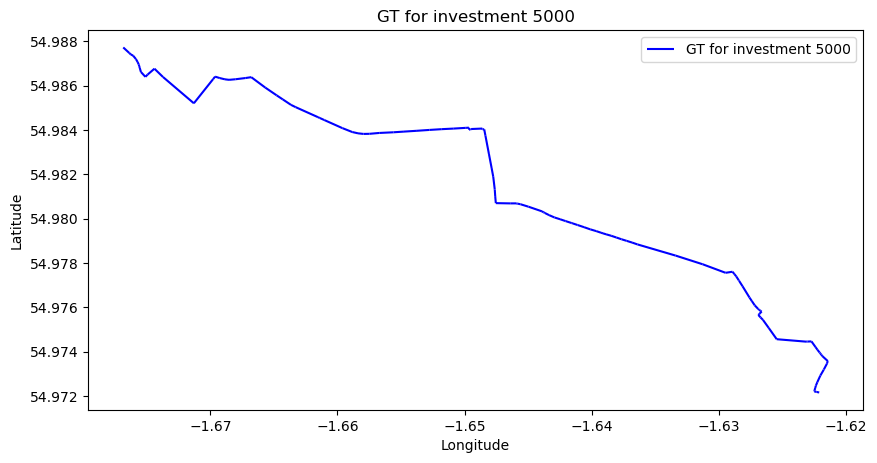

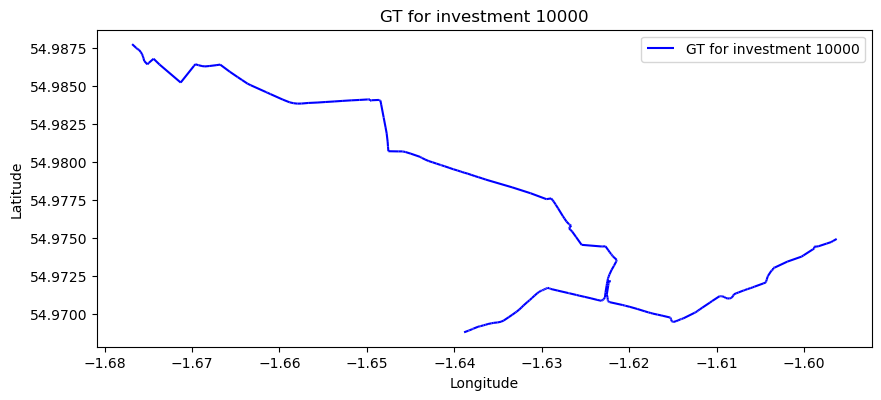

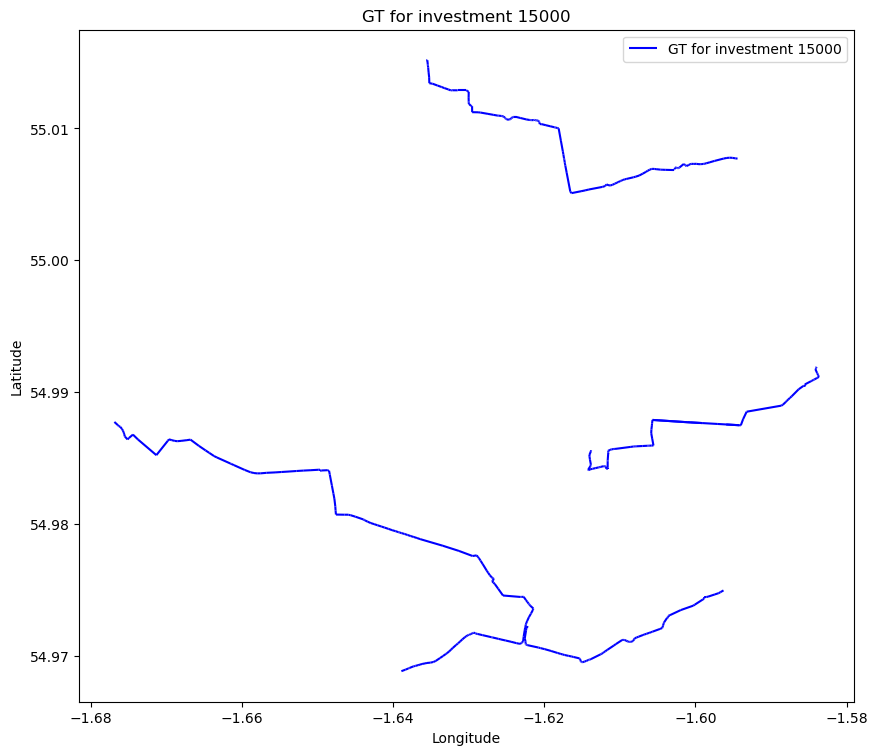

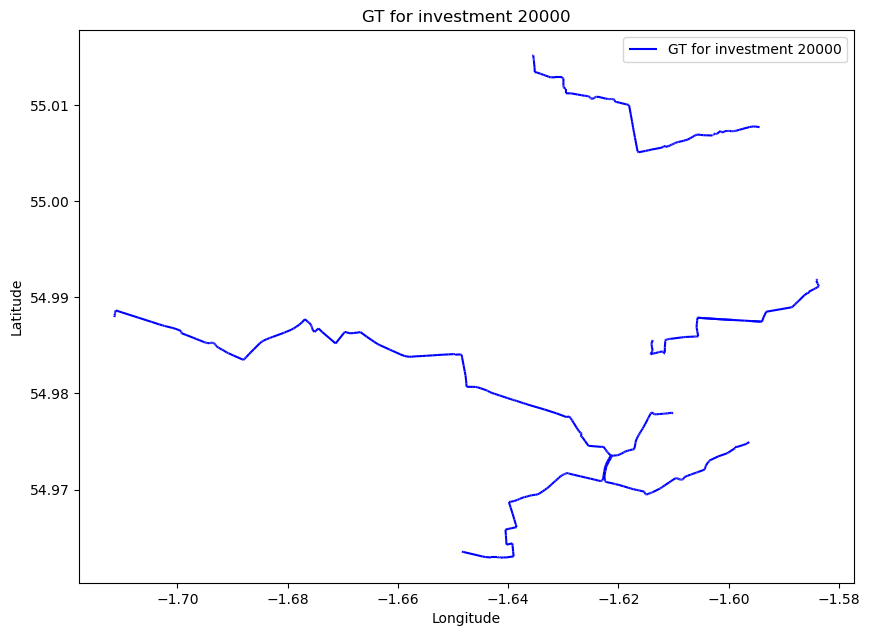

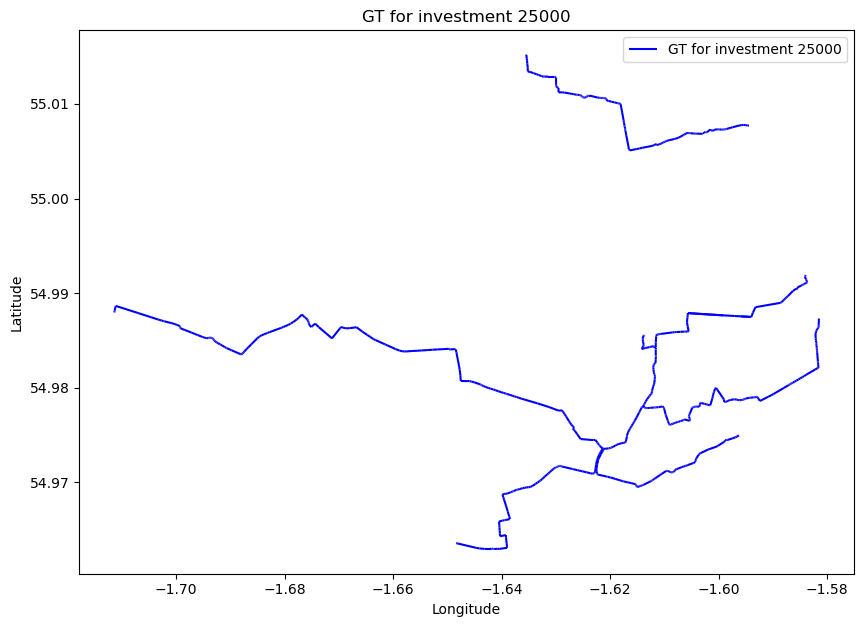

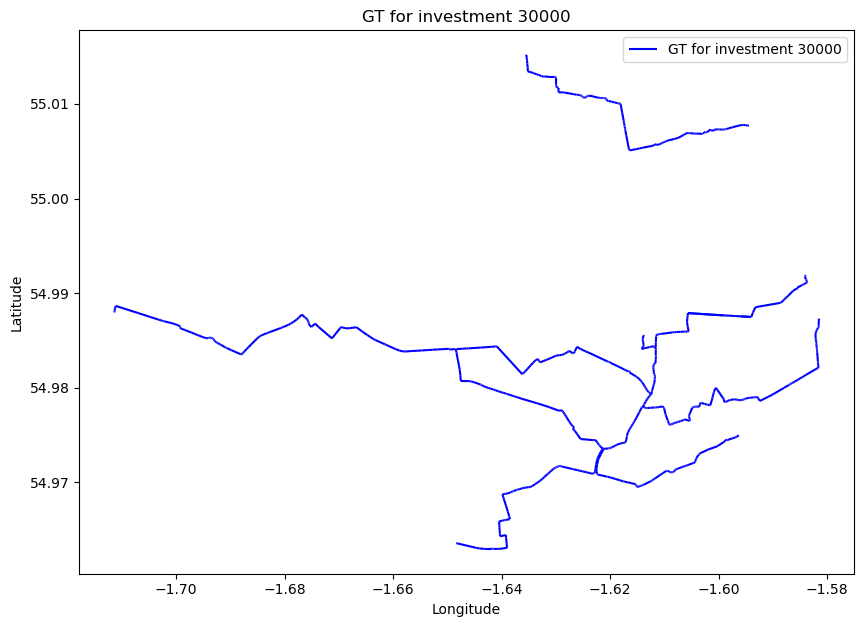

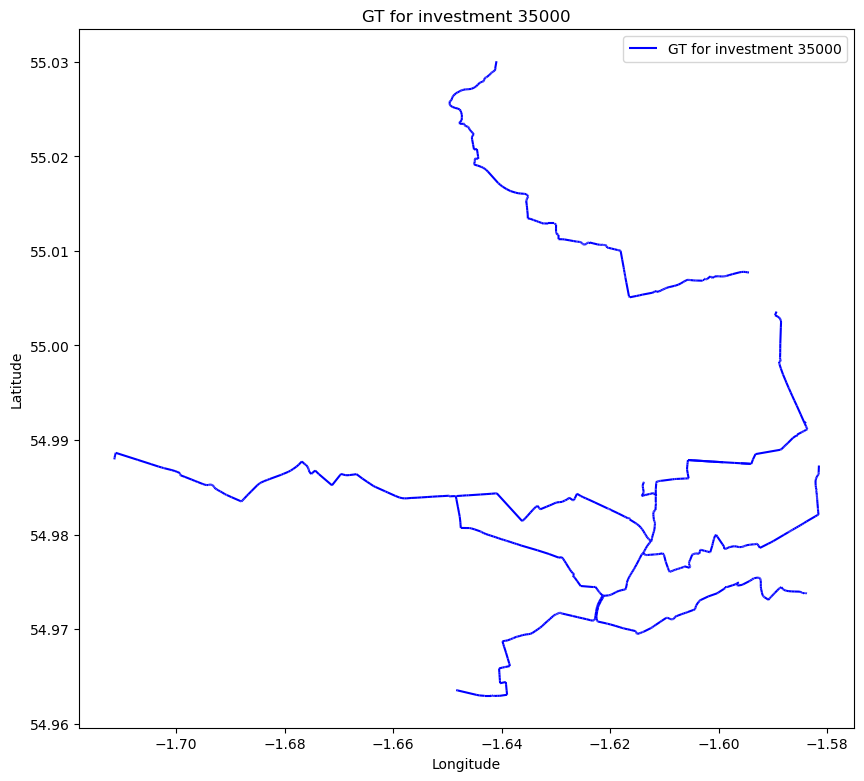

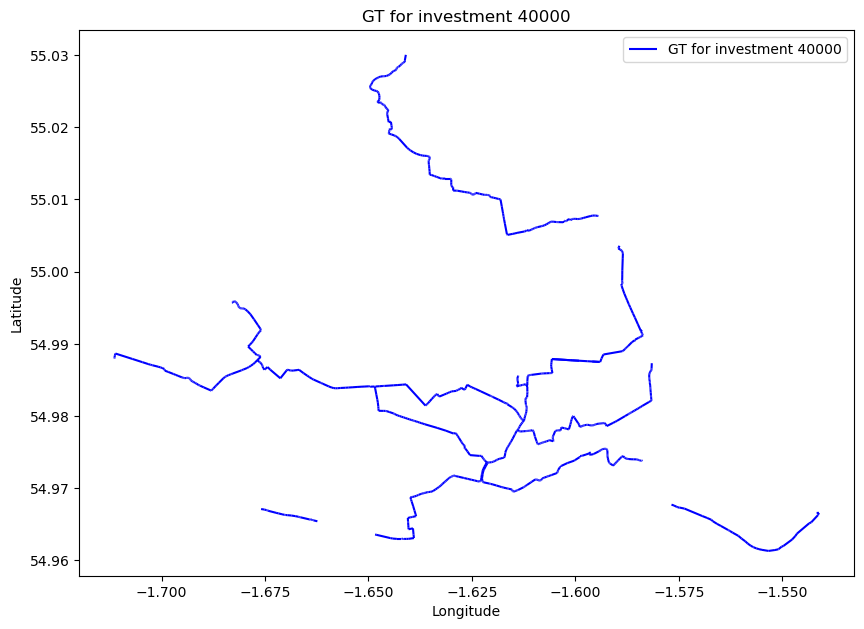

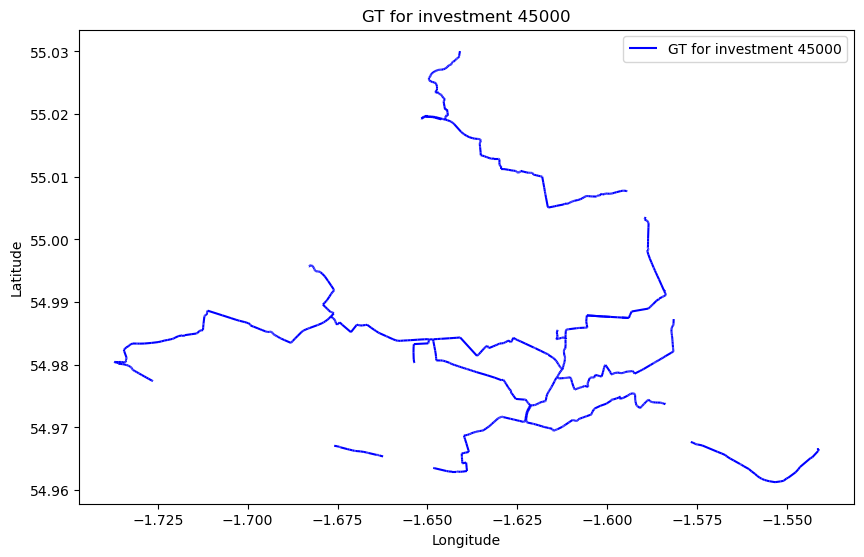

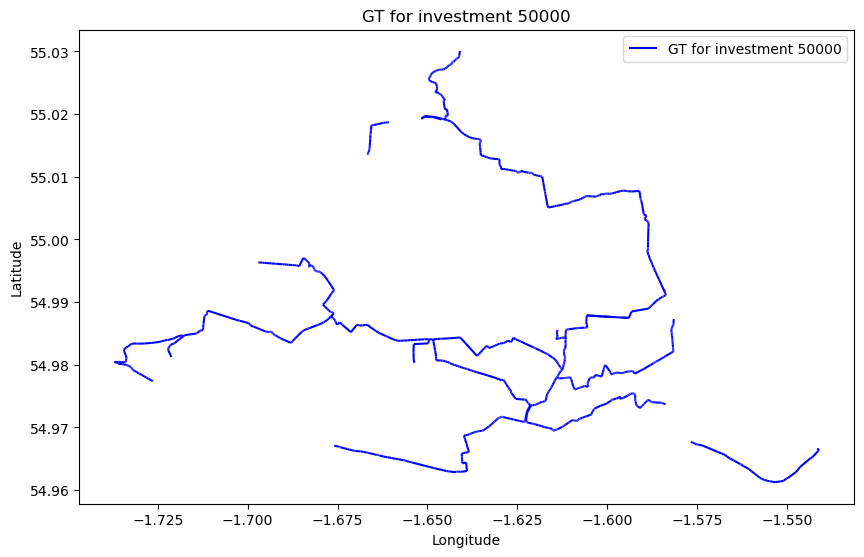

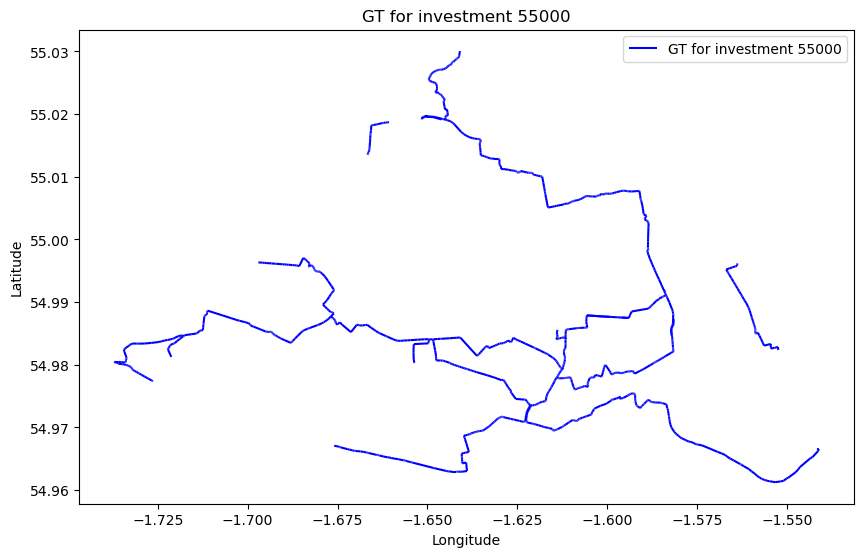

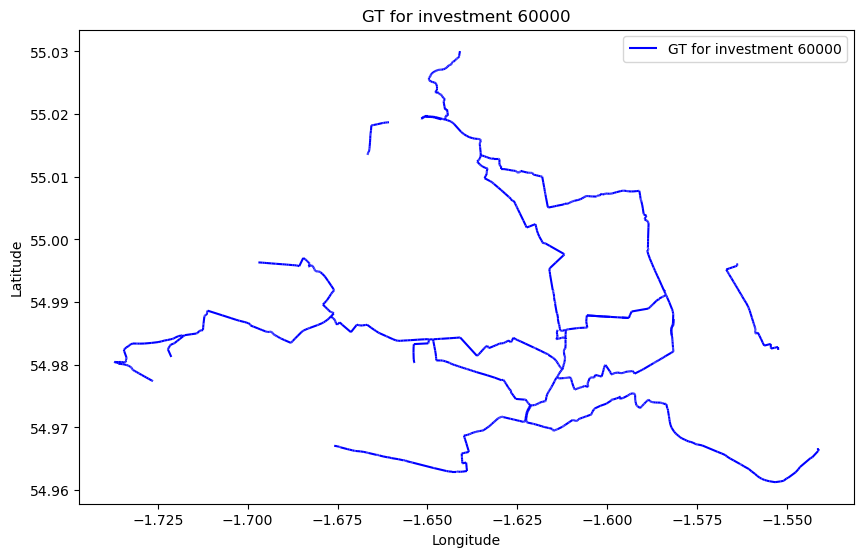

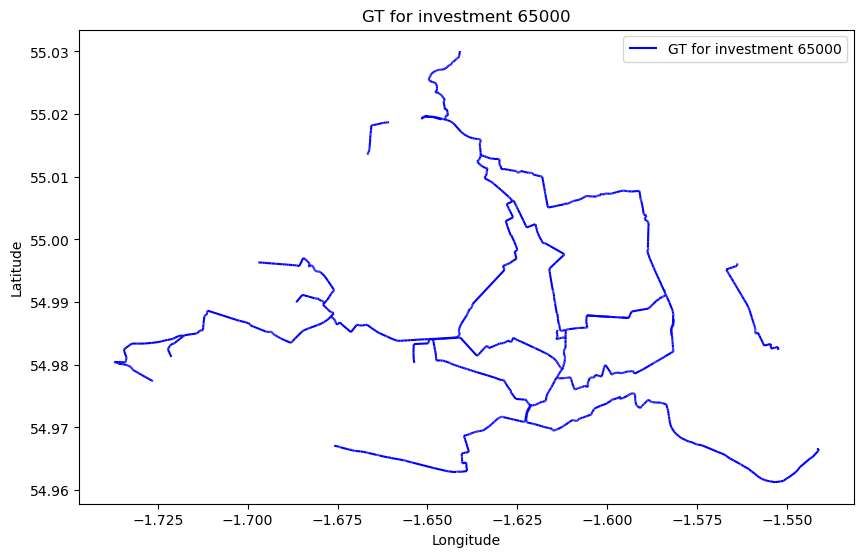

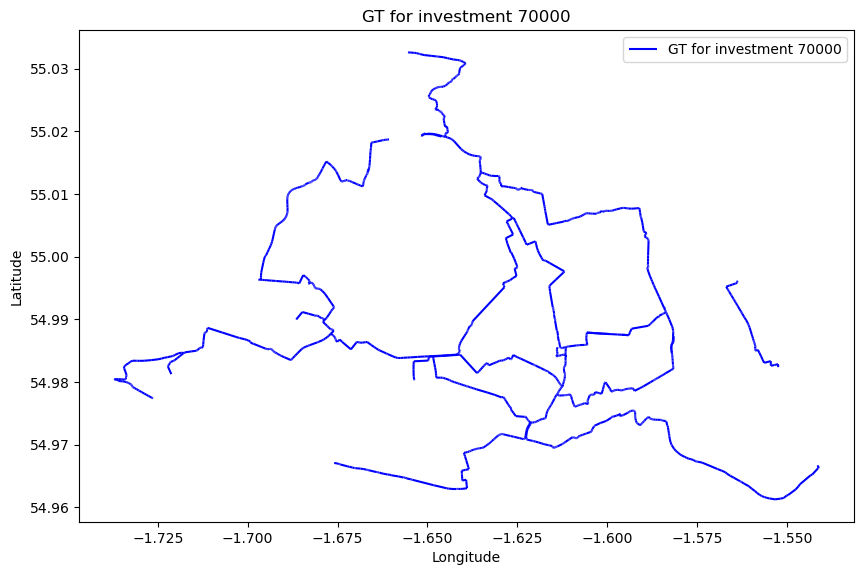

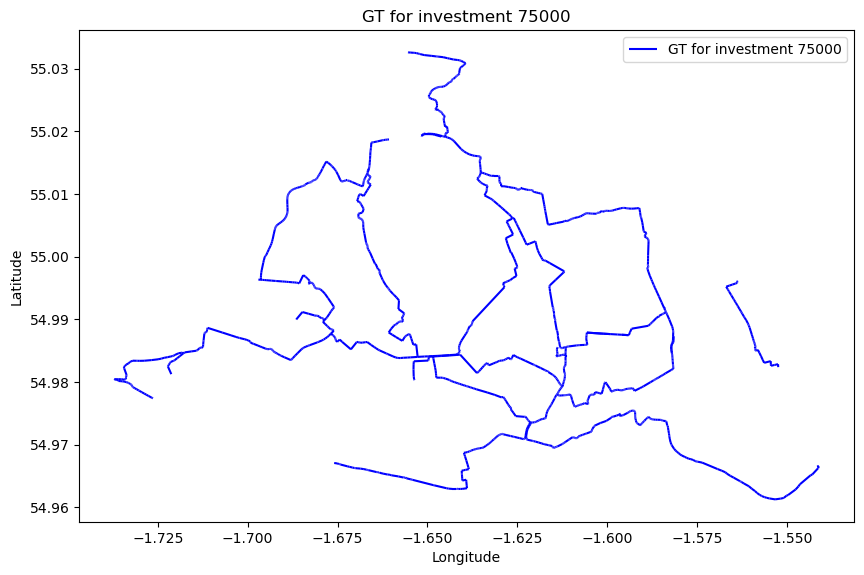

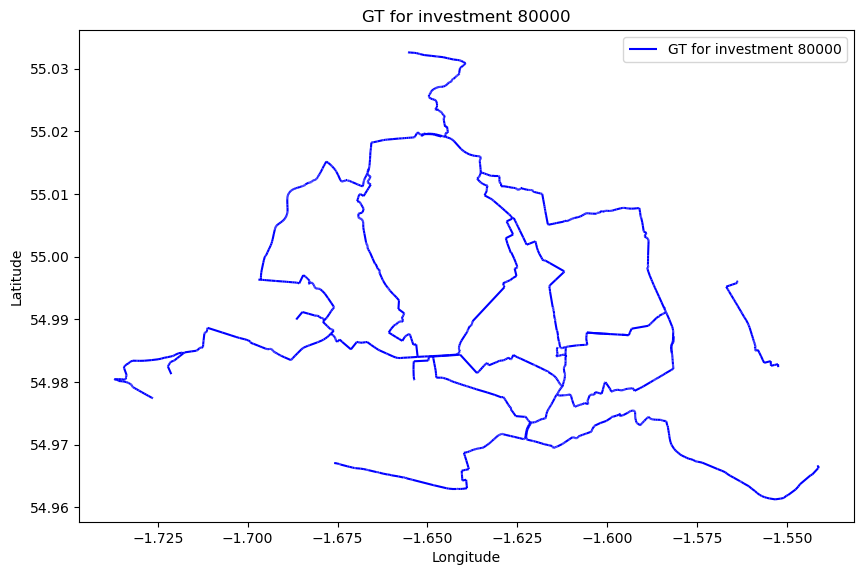

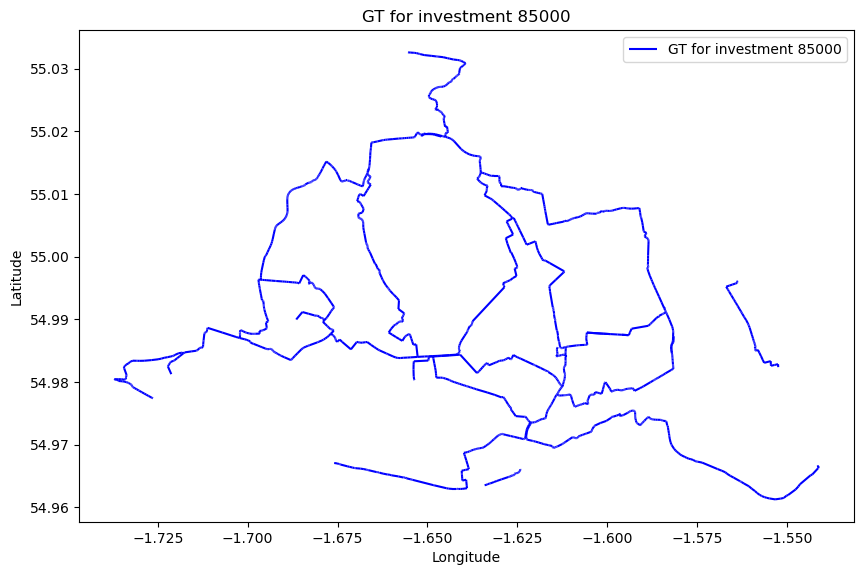

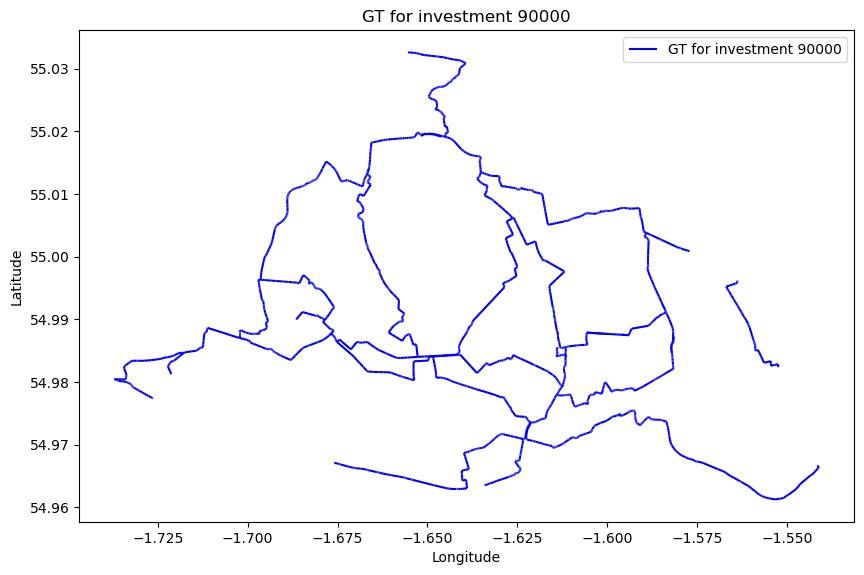

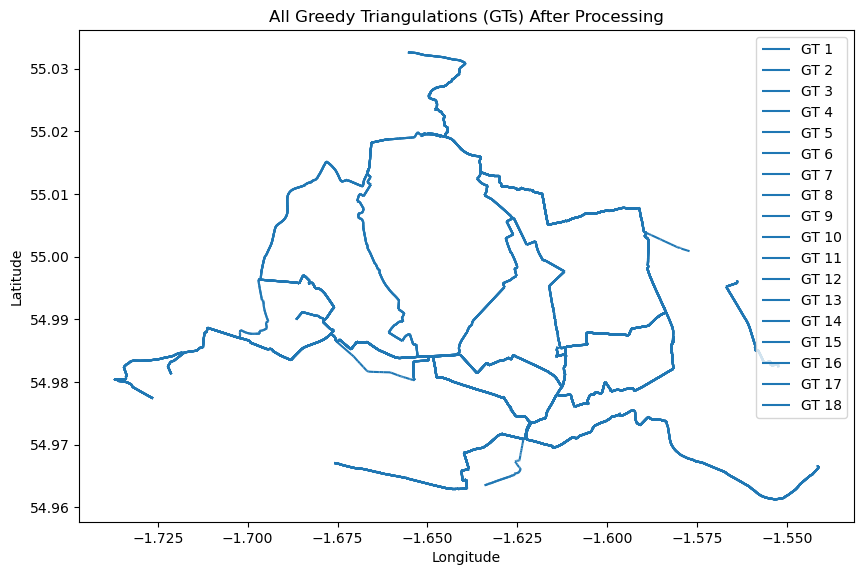

In [30]:
investment_levels = list(np.arange(5000,95000,5000))




for placeid, placeinfo in tqdm(cities.items(), desc="Cities"):
    print(f"{placeid}: Generating networks")

    # Load networks
    G_carall = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'biketrackcarall', weighting=weighting)

    # Load POIs
    with open(PATH["data"] + placeid + "/" + placeid + '_poi_' + poi_source + '_nnidsbikeall.csv') as f:
        nnids = [int(line.rstrip()) for line in f]

    # Generation
    (GTs, GT_abstracts) = greedy_triangulation_routing(G_carall, nnids, weighting, investment_levels, prune_measure)
    (MST, MST_abstract) = mst_routing(G_carall, nnids, weighting)

    # Restore original edge lengths
    if weighting:
        restore_original_lengths(G_carall)
        for GT in GTs:
            restore_original_lengths(GT)
        restore_original_lengths(MST)

    # Write results
    results = {
        "placeid": placeid,
        "prune_measure": prune_measure,
        "poi_source": poi_source,
        "investment_levels": investment_levels,
        "GTs": GTs,
        "GT_abstracts": GT_abstracts,
        "MST": MST,
        "MST_abstract": MST_abstract
    }
    #write_result(results, "pickle", placeid, poi_source, prune_measure, ".pickle", weighting=weighting)


In [31]:
import geopandas as gpd
from shapely.geometry import shape
import os

# Function to convert iGraph to GeoDataFrame
def igraph_to_geodataframe(graph):
    """
    Convert an iGraph graph to a GeoDataFrame.
    """
    GT_gjson = ig_to_geojson(graph)
    GT_geometries = [shape(geometry) for geometry in GT_gjson["geometries"]]
    return gpd.GeoDataFrame(geometry=GT_geometries, crs="EPSG:4326")

# Folder path to save GeoPackage
output_folder = r"C:\Users\b8008458\Documents\scratch_space\gts"
geopackage_path = os.path.join(output_folder, "greedy_triangulations.gpkg")

# Remove existing GeoPackage if needed (optional)
if os.path.exists(geopackage_path):
    os.remove(geopackage_path)

# Function to save a list of graphs to a GeoPackage
def save_graphs_to_geopackage(graphs, geopackage_path, prefix):
    """
    Save a list of iGraph graphs to a GeoPackage, each as a separate layer.
    """
    for idx, graph in enumerate(graphs):
        try:
            # Convert to GeoDataFrame
            gdf = igraph_to_geodataframe(graph)
            
            # Layer name with prefix
            layer_name = f"{prefix}_graph_{idx}"
            
            # Save to GeoPackage
            gdf.to_file(geopackage_path, layer=layer_name, driver="GPKG")
            print(f"Saved {layer_name} to GeoPackage.")
        except Exception as e:
            print(f"Failed to save {prefix}_graph_{idx}: {e}")

# Save GT_abstracts and GTs
save_graphs_to_geopackage(GT_abstracts, geopackage_path, "GT_abstract")
save_graphs_to_geopackage(GTs, geopackage_path, "GT")


Saved GT_abstract_graph_0 to GeoPackage.
Saved GT_abstract_graph_1 to GeoPackage.
Saved GT_abstract_graph_2 to GeoPackage.
Saved GT_abstract_graph_3 to GeoPackage.
Saved GT_abstract_graph_4 to GeoPackage.
Saved GT_abstract_graph_5 to GeoPackage.
Saved GT_abstract_graph_6 to GeoPackage.
Saved GT_abstract_graph_7 to GeoPackage.
Saved GT_abstract_graph_8 to GeoPackage.
Saved GT_abstract_graph_9 to GeoPackage.
Saved GT_abstract_graph_10 to GeoPackage.
Saved GT_abstract_graph_11 to GeoPackage.
Saved GT_abstract_graph_12 to GeoPackage.
Saved GT_abstract_graph_13 to GeoPackage.
Saved GT_abstract_graph_14 to GeoPackage.
Saved GT_abstract_graph_15 to GeoPackage.
Saved GT_abstract_graph_16 to GeoPackage.
Saved GT_abstract_graph_17 to GeoPackage.
Saved GT_graph_0 to GeoPackage.
Saved GT_graph_1 to GeoPackage.
Saved GT_graph_2 to GeoPackage.
Saved GT_graph_3 to GeoPackage.
Saved GT_graph_4 to GeoPackage.
Saved GT_graph_5 to GeoPackage.
Saved GT_graph_6 to GeoPackage.
Saved GT_graph_7 to GeoPackage

In [32]:
Audio(sound_file, autoplay=True)